Nama : Sarah Natalia Geraldine

NIM  : 121450022

Judul TA : Prediksi Harga Penutupan Saham PT. Bukit Asam Tbk Menggunakan Model Autoformer

# Persiapan lingkungan

In [ ]:
!pip install pandas scikit-learn torch numpy matplotlib sympy einops

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.preprocessing import StandardScaler
import datetime
import math
from math import sqrt, log2, ceil
from functools import partial
from typing import List, Tuple
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import os
import time
from torch import optim
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install torchinfo

In [ ]:
def set_seed(seed=2021):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2021)

# Data

In [ ]:
import pandas as pd

file_path = '/content/PTBA.csv'
df = pd.read_csv(file_path)
df.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M:%S')
df = df.sort_values('date')

df.head(90)

,date,close
0,2020-01-02 16:00:00,2630
1,2020-01-03 16:00:00,2670
2,2020-01-06 16:00:00,2730
3,2020-01-07 16:00:00,2710
4,2020-01-08 16:00:00,2670
...,...,...
85,2020-05-05 16:00:00,1815
86,2020-05-06 16:00:00,1895
87,2020-05-08 16:00:00,2060
88,2020-05-11 16:00:00,2050


In [ ]:
processed_file_path = '/content/processed.csv'
df.to_csv(processed_file_path, index=False)

df.describe()

,date,close
count,1212,1212.000000
mean,2022-06-29 18:37:01.782178304,2849.311056
min,2020-01-02 16:00:00,1485.000000
25%,2021-04-01 09:00:00,2377.500000
50%,2022-07-03 04:00:00,2720.000000
75%,2023-09-26 22:00:00,3262.500000
max,2025-01-02 16:00:00,4630.000000
std,NaN,652.925545


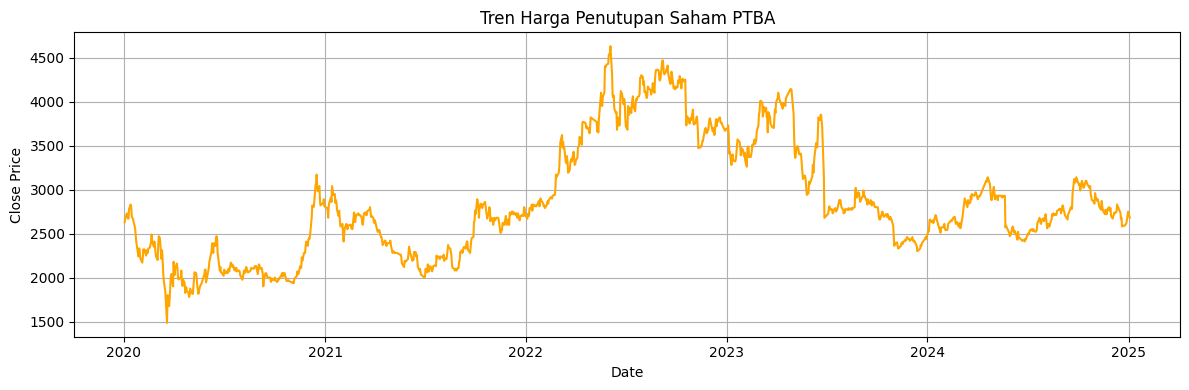

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['close'], color='orange')

plt.title('Tren Harga Penutupan Saham PTBA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# utils

## masking

In [ ]:
import torch

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
    @property
    def mask(self):
        return self._mask

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)
    @property
    def mask(self):
        return self._mask

class LocalMask():
    def __init__(self, B, L,S,device="cpu"):
        mask_shape = [B, 1, L, S]
        with torch.no_grad():
            self.len = math.ceil(np.log2(L))
            self._mask1 = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
            self._mask2 = ~torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=-self.len).to(device)
            self._mask = self._mask1+self._mask2
    @property
    def mask(self):
        return self._mask

## metrics

In [ ]:
import numpy as np

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))

def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2).sum(0) * ((pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    return mae, mse, rmse, mape, mspe

## time features

In [ ]:
import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from typing import List

class TimeFeature:
    def __init__(self):
        pass
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass
    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    from pandas.tseries import offsets
    from pandas.tseries.frequencies import to_offset

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, freq='h'):
    if isinstance(dates, pd.Series):
        dates = pd.to_datetime(dates).dt.to_pydatetime()
        dates = pd.DatetimeIndex(dates)
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

## Utils, EarlyStopping & Visualisasi

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.switch_backend('agg')

def adjust_learning_rate(optimizer, epoch, args):
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj =='type3':
        lr_adjust = {epoch: args.learning_rate}
    elif args.lradj == 'type4':
        lr_adjust = {epoch: args.learning_rate * (0.9 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def transform(self, data):
        return (data - self.mean) / self.std
    def inverse_transform(self, data):
        return (data * self.std) + self.mean

def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')

### utils

In [ ]:
def legendreDer(k, x):
    def _legendre(k, x):
        return (2*k+1) * eval_legendre(k, x)
    out = 0
    for i in np.arange(k-1,-1,-2):
        out += _legendre(i, x)
    return out

def phi_(phi_c, x, lb = 0, ub = 1):
    mask = np.logical_or(x<lb, x>ub) * 1.0
    return np.polynomial.polynomial.Polynomial(phi_c)(x) * (1-mask)

def get_phi_psi(k, base):
    x = Symbol('x')
    phi_coeff = np.zeros((k,k))
    phi_2x_coeff = np.zeros((k,k))
    if base == 'legendre':
        for ki in range(k):
            coeff_ = Poly(legendre(ki, 2*x-1), x).all_coeffs()
            phi_coeff[ki,:ki+1] = np.flip(np.sqrt(2*ki+1) * np.array(coeff_).astype(np.float64))
            coeff_ = Poly(legendre(ki, 4*x-1), x).all_coeffs()
            phi_2x_coeff[ki,:ki+1] = np.flip(np.sqrt(2) * np.sqrt(2*ki+1) * np.array(coeff_).astype(np.float64))

        psi1_coeff = np.zeros((k, k))
        psi2_coeff = np.zeros((k, k))
        for ki in range(k):
            psi1_coeff[ki,:] = phi_2x_coeff[ki,:]
            for i in range(k):
                a = phi_2x_coeff[ki,:ki+1]
                b = phi_coeff[i, :i+1]
                prod_ = np.convolve(a, b)
                prod_[np.abs(prod_)<1e-8] = 0
                proj_ = (prod_ * 1/(np.arange(len(prod_))+1) * np.power(0.5, 1+np.arange(len(prod_)))).sum()
                psi1_coeff[ki,:] -= proj_ * phi_coeff[i,:]
                psi2_coeff[ki,:] -= proj_ * phi_coeff[i,:]
            for j in range(ki):
                a = phi_2x_coeff[ki,:ki+1]
                b = psi1_coeff[j, :]
                prod_ = np.convolve(a, b)
                prod_[np.abs(prod_)<1e-8] = 0
                proj_ = (prod_ * 1/(np.arange(len(prod_))+1) * np.power(0.5, 1+np.arange(len(prod_)))).sum()
                psi1_coeff[ki,:] -= proj_ * psi1_coeff[j,:]
                psi2_coeff[ki,:] -= proj_ * psi2_coeff[j,:]

            a = psi1_coeff[ki,:]
            prod_ = np.convolve(a, a)
            prod_[np.abs(prod_)<1e-8] = 0
            norm1 = (prod_ * 1/(np.arange(len(prod_))+1) * np.power(0.5, 1+np.arange(len(prod_)))).sum()

            a = psi2_coeff[ki,:]
            prod_ = np.convolve(a, a)
            prod_[np.abs(prod_)<1e-8] = 0
            norm2 = (prod_ * 1/(np.arange(len(prod_))+1) * (1-np.power(0.5, 1+np.arange(len(prod_))))).sum()
            norm_ = np.sqrt(norm1 + norm2)
            psi1_coeff[ki,:] /= norm_
            psi2_coeff[ki,:] /= norm_
            psi1_coeff[np.abs(psi1_coeff)<1e-8] = 0
            psi2_coeff[np.abs(psi2_coeff)<1e-8] = 0

        phi = [np.poly1d(np.flip(phi_coeff[i,:])) for i in range(k)]
        psi1 = [np.poly1d(np.flip(psi1_coeff[i,:])) for i in range(k)]
        psi2 = [np.poly1d(np.flip(psi2_coeff[i,:])) for i in range(k)]

    elif base == 'chebyshev':
        for ki in range(k):
            if ki == 0:
                phi_coeff[ki,:ki+1] = np.sqrt(2/np.pi)
                phi_2x_coeff[ki,:ki+1] = np.sqrt(2/np.pi) * np.sqrt(2)
            else:
                coeff_ = Poly(chebyshevt(ki, 2*x-1), x).all_coeffs()
                phi_coeff[ki,:ki+1] = np.flip(2/np.sqrt(np.pi) * np.array(coeff_).astype(np.float64))
                coeff_ = Poly(chebyshevt(ki, 4*x-1), x).all_coeffs()
                phi_2x_coeff[ki,:ki+1] = np.flip(np.sqrt(2) * 2 / np.sqrt(np.pi) * np.array(coeff_).astype(np.float64))

        phi = [partial(phi_, phi_coeff[i,:]) for i in range(k)]

        kUse = 2*k
        roots = Poly(chebyshevt(kUse, 2*x-1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        wm = np.pi / kUse / 2

        psi1_coeff = np.zeros((k, k))
        psi2_coeff = np.zeros((k, k))

        psi1 = [[] for _ in range(k)]
        psi2 = [[] for _ in range(k)]

        for ki in range(k):
            psi1_coeff[ki,:] = phi_2x_coeff[ki,:]
            for i in range(k):
                proj_ = (wm * phi[i](x_m) * np.sqrt(2)* phi[ki](2*x_m)).sum()
                psi1_coeff[ki,:] -= proj_ * phi_coeff[i,:]
                psi2_coeff[ki,:] -= proj_ * phi_coeff[i,:]

            for j in range(ki):
                proj_ = (wm * psi1[j](x_m) * np.sqrt(2) * phi[ki](2*x_m)).sum()
                psi1_coeff[ki,:] -= proj_ * psi1_coeff[j,:]
                psi2_coeff[ki,:] -= proj_ * psi2_coeff[j,:]

            psi1[ki] = partial(phi_, psi1_coeff[ki,:], lb = 0, ub = 0.5)
            psi2[ki] = partial(phi_, psi2_coeff[ki,:], lb = 0.5, ub = 1)

            norm1 = (wm * psi1[ki](x_m) * psi1[ki](x_m)).sum()
            norm2 = (wm * psi2[ki](x_m) * psi2[ki](x_m)).sum()

            norm_ = np.sqrt(norm1 + norm2)
            psi1_coeff[ki,:] /= norm_
            psi2_coeff[ki,:] /= norm_
            psi1_coeff[np.abs(psi1_coeff)<1e-8] = 0
            psi2_coeff[np.abs(psi2_coeff)<1e-8] = 0

            psi1[ki] = partial(phi_, psi1_coeff[ki,:], lb = 0, ub = 0.5+1e-16)
            psi2[ki] = partial(phi_, psi2_coeff[ki,:], lb = 0.5+1e-16, ub = 1)

    return phi, psi1, psi2

def get_filter(base, k):
    def psi(psi1, psi2, i, inp):
        mask = (inp<=0.5) * 1.0
        return psi1[i](inp) * mask + psi2[i](inp) * (1-mask)

    if base not in ['legendre', 'chebyshev']:
        raise Exception('Base not supported')

    x = Symbol('x')
    H0 = np.zeros((k,k))
    H1 = np.zeros((k,k))
    G0 = np.zeros((k,k))
    G1 = np.zeros((k,k))
    PHI0 = np.zeros((k,k))
    PHI1 = np.zeros((k,k))
    phi, psi1, psi2 = get_phi_psi(k, base)
    if base == 'legendre':
        roots = Poly(legendre(k, 2*x-1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        wm = 1/k/legendreDer(k,2*x_m-1)/eval_legendre(k-1,2*x_m-1)

        for ki in range(k):
            for kpi in range(k):
                H0[ki, kpi] = 1/np.sqrt(2) * (wm * phi[ki](x_m/2) * phi[kpi](x_m)).sum()
                G0[ki, kpi] = 1/np.sqrt(2) * (wm * psi(psi1, psi2, ki, x_m/2) * phi[kpi](x_m)).sum()
                H1[ki, kpi] = 1/np.sqrt(2) * (wm * phi[ki]((x_m+1)/2) * phi[kpi](x_m)).sum()
                G1[ki, kpi] = 1/np.sqrt(2) * (wm * psi(psi1, psi2, ki, (x_m+1)/2) * phi[kpi](x_m)).sum()

        PHI0 = np.eye(k)
        PHI1 = np.eye(k)

    elif base == 'chebyshev':
        x = Symbol('x')
        kUse = 2*k
        roots = Poly(chebyshevt(kUse, 2*x-1)).all_roots()
        x_m = np.array([rt.evalf(20) for rt in roots]).astype(np.float64)
        wm = np.pi / kUse / 2

        for ki in range(k):
            for kpi in range(k):
                H0[ki, kpi] = 1/np.sqrt(2) * (wm * phi[ki](x_m/2) * phi[kpi](x_m)).sum()
                G0[ki, kpi] = 1/np.sqrt(2) * (wm * psi(psi1, psi2, ki, x_m/2) * phi[kpi](x_m)).sum()
                H1[ki, kpi] = 1/np.sqrt(2) * (wm * phi[ki]((x_m+1)/2) * phi[kpi](x_m)).sum()
                G1[ki, kpi] = 1/np.sqrt(2) * (wm * psi(psi1, psi2, ki, (x_m+1)/2) * phi[kpi](x_m)).sum()

                PHI0[ki, kpi] = (wm * phi[ki](2*x_m) * phi[kpi](2*x_m)).sum() * 2
                PHI1[ki, kpi] = (wm * phi[ki](2*x_m-1) * phi[kpi](2*x_m-1)).sum() * 2

        PHI0[np.abs(PHI0)<1e-8] = 0
        PHI1[np.abs(PHI1)<1e-8] = 0

    H0[np.abs(H0)<1e-8] = 0
    H1[np.abs(H1)<1e-8] = 0
    G0[np.abs(G0)<1e-8] = 0
    G1[np.abs(G1)<1e-8] = 0

    return H0, H1, G0, G1, PHI0, PHI1

# embedding

In [ ]:
import torch
import torch.nn as nn
import math

# Membandingkan versi PyTorch
def compared_version(ver1, ver2):
    list1 = str(ver1).split(".")
    list2 = str(ver2).split(".")
    for i in range(len(list1)) if len(list1) < len(list2) else range(len(list2)):
        if int(list1[i]) == int(list2[i]):
            pass
        elif int(list1[i]) < int(list2[i]):
            return -1
        else:
            return 1
    if len(list1) == len(list2):
        return True
    elif len(list1) < len(list2):
        return False
    else:
        return True

# Value embedding
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if compared_version(torch.__version__, '1.5.0') else 2
        self.tokenConv = nn.Conv1d(
            in_channels=c_in, out_channels=d_model,
            kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

# Fixed embedding
class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()
        w = torch.zeros(c_in, d_model).float()
        w.requires_grad = False
        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)
        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

# Temporal embedding
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()
        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13
        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])
        return hour_x + weekday_x + day_x + month_x + minute_x

# Time feature embedding
class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()
        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)

# Data embedding tanpa positional embedding
class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

# autocorrelation

In [ ]:
import torch
import torch.nn as nn
import math


class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, n=L, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

# encoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

# decoder

In [ ]:
class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend

In [ ]:
def get_frequency_modes(seq_len, modes=64, mode_select_method='random'):
    """ Selects frequency modes using the specified method. """
    modes = min(modes, seq_len // 2)
    if mode_select_method == 'random':
        index = list(range(0, seq_len // 2))
        np.random.shuffle(index)
        index = index[:modes]
        index = sorted(index)
    else:
        index = list(range(0, modes))
    return index

# Class Models

In [ ]:
import torch
import torch.nn as nn

class ModelAutoformer(nn.Module):
    """
    Autoformer is the first method to achieve the series-wise connection,
    with inherent O(LlogL) complexity
    """
    def __init__(self, configs):
        super(ModelAutoformer, self).__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Decomp
        kernel_size = configs.moving_avg
        if isinstance(kernel_size, list):
            self.decomp = series_decomp(kernel_size[0])
        else:
            self.decomp = series_decomp(kernel_size)

        # Embedding
        self.enc_embedding = DataEmbedding_wo_pos(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)
        self.dec_embedding = DataEmbedding_wo_pos(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.c_out,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]

# Class dataset

In [ ]:
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

class PTBADataset(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ptba.csv',
                 target='close', scale=True, timeenc=0, freq='d'):
        if size is None:
            self.seq_len = 96
            self.label_len = 48
            self.pred_len = 24
        else:
            self.seq_len, self.label_len, self.pred_len = size

        assert flag in ['train', 'test', 'val']
        self.set_type = {'train': 0, 'val': 1, 'test': 2}[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = SklearnStandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path))

        df_raw['date'] = pd.to_datetime(df_raw['date'])
        df_raw = df_raw[['date', self.target]]

        num_train = int(len(df_raw) * 0.7)
        num_vali  = int(len(df_raw) * 0.1)
        num_test  = len(df_raw) - num_train - num_vali

        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]

        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp['date'])

        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.dt.month
            df_stamp['day'] = df_stamp.date.dt.day
            df_stamp['weekday'] = df_stamp.date.dt.weekday
            df_stamp['hour'] = 0
            data_stamp = df_stamp.drop(['date'], axis=1).values
        else:
            data_stamp = time_features(df_stamp['date'], freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ptba.csv',
                 target='close', scale=True, inverse=False, timeenc=0, freq='d', cols=None):
        if size is None:
            self.seq_len = 96
            self.label_len = 48
            self.pred_len = 24
        else:
            self.seq_len, self.label_len, self.pred_len = size

        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = SklearnStandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path))
        df_raw['date'] = pd.to_datetime(df_raw['date'])
        df_raw = df_raw[['date', self.target]]

        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])

        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], axis=1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

def data_provider(args, flag):
    data_dict = {
        'ptba': PTBADataset
    }

    timeenc = 0 if args.embed != 'timeF' else 1

    if flag == 'pred':
        data_set = Dataset_Pred(
            root_path=args.root_path,
            flag='pred',
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            data_path=args.data_path,
            target=args.target,
            scale=True,
            inverse=False,
            timeenc=timeenc,
            freq=args.freq
        )
        print(f"Prediction set size: {len(data_set)}")
        data_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)
        return data_set, data_loader

    else:
        Data = data_dict[args.data]
        if flag == 'test':
            shuffle_flag = False
            drop_last = True
            batch_size = args.batch_size
            freq = args.freq
        else:
            shuffle_flag = True
            drop_last = True
            batch_size = args.batch_size
            freq = args.freq

        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            timeenc=timeenc,
            freq=freq
        )
        print(f"{flag} set size: {len(data_set)}")

        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last
        )
        return data_set, data_loader

# Exp

In [ ]:
import os
import time
import logging
import warnings
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.optim as optim
import matplotlib.pyplot as plt

class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError

    def _acquire_device(self):
        if self.args.use_gpu:
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self, *args, **kwargs):
        pass

    def vali(self, *args, **kwargs):
        pass

    def train(self, *args, **kwargs):
        pass

    def test(self, *args, **kwargs):
        pass

In [ ]:
import os, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class Exp_Main(Exp_Basic):
    def __init__(self, args):
        super(Exp_Main, self).__init__(args)

    def _build_model(self):
        model_dict = {
            'ModelAutoformer': ModelAutoformer,
        }
        model = model_dict[self.args.model](self.args).float()

        if getattr(self.args, 'use_multi_gpu', False) and getattr(self.args, 'use_gpu', False):
            device_ids = getattr(self.args, 'device_ids', None)
            if device_ids is None:
                devices_str = getattr(self.args, 'devices', '0')
                device_ids = [int(x) for x in str(devices_str).split(',')]
            model = nn.DataParallel(model, device_ids=device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                        if self.args.output_attention:
                            outputs = outputs[0]
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    if self.args.output_attention:
                        outputs = outputs[0]

                f_dim = -1 if self.args.features == 'MS' else 0
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                loss = criterion(outputs, batch_y)
                total_loss.append(loss.item())

        avg_loss = float(np.mean(total_loss)) if len(total_loss) > 0 else np.nan
        self.model.train()
        return avg_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')

        path = os.path.join('./checkpoints', setting)
        os.makedirs(path, exist_ok=True)

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        train_loss_list, vali_loss_list, epoch_list = [], [], []
        best_val = float('inf')

        for epoch in range(self.args.train_epochs):
            iter_count, train_loss = 0, []
            self.model.train()
            epoch_time = time.time()

            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()

                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                        if self.args.output_attention:
                            outputs = outputs[0]
                        f_dim = -1 if self.args.features == 'MS' else 0
                        gt = batch_y[:, -self.args.pred_len:, f_dim:]
                        loss = criterion(outputs, gt)
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    if self.args.output_attention:
                        outputs = outputs[0]
                    f_dim = -1 if self.args.features == 'MS' else 0
                    gt = batch_y[:, -self.args.pred_len:, f_dim:]
                    loss = criterion(outputs, gt)

                train_loss.append(loss.item())

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            train_loss = float(np.mean(train_loss)) if len(train_loss) > 0 else np.nan
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            best_val = min(best_val, vali_loss)

            epoch_list.append(epoch + 1)
            train_loss_list.append(train_loss)
            vali_loss_list.append(vali_loss)

            print(f"Epoch: {epoch+1}, Steps: {train_steps} | Train Loss: {train_loss:.7f}  Vali Loss: {vali_loss:.7f} "
                  f"Time: {time.time()-epoch_time:.2f}s")

            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = os.path.join(path, 'checkpoint.pth')
        self.model.load_state_dict(torch.load(best_model_path))

        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.plot(epoch_list, train_loss_list, marker='o', label='Train Loss')
            plt.plot(epoch_list, vali_loss_list, marker='s', label='Validation Loss')
            plt.xticks(epoch_list)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training & Validation Loss per Epoch')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Plot error:", e)

        return best_val

    def retrain(self, setting, trainval_loader):
        print(">>>>> Retrain dengan data Train+Val >>>>>")
        path = os.path.join('./checkpoints', setting + "_retrain")
        os.makedirs(path, exist_ok=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()
        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        train_loss_list, epoch_list = [], []
        for epoch in range(self.args.train_epochs):
            epoch_time, train_loss = time.time(), []
            self.model.train()

            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(trainval_loader):
                model_optim.zero_grad()

                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                        if self.args.output_attention:
                            outputs = outputs[0]
                        f_dim = -1 if self.args.features == 'MS' else 0
                        gt = batch_y[:, -self.args.pred_len:, f_dim:]
                        loss = criterion(outputs, gt)
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    if self.args.output_attention:
                        outputs = outputs[0]
                    f_dim = -1 if self.args.features == 'MS' else 0
                    gt = batch_y[:, -self.args.pred_len:, f_dim:]
                    loss = criterion(outputs, gt)

                train_loss.append(loss.item())

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            train_loss = float(np.mean(train_loss)) if len(train_loss) > 0 else np.nan
            epoch_list.append(epoch + 1)
            train_loss_list.append(train_loss)

            print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.7f}, Time: {time.time()-epoch_time:.2f}s")
            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = os.path.join(path, 'checkpoint_retrain.pth')
        torch.save(self.model.state_dict(), best_model_path)
        print(f"Retrain selesai. Model disimpan di {best_model_path}")

        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.plot(epoch_list, train_loss_list, marker='o', label='Train Loss')
            plt.xticks(epoch_list)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Retrain Loss per Epoch')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Plot error:", e)

        return np.min(train_loss_list)

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds, trues = [], []
        folder_path = './test_results/' + setting + '/'
        os.makedirs(folder_path, exist_ok=True)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                if self.args.output_attention:
                    outputs = outputs[0]

                f_dim = -1 if self.args.features == 'MS' else 0
                gt = batch_y[:, -self.args.pred_len:, f_dim:]

                preds.append(outputs.detach().cpu().numpy())
                trues.append(gt.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        mae, mse, rmse, mape, mspe = metric(preds, trues)

        print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}')
        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        with open("result.txt", 'a') as f:
            f.write(f"{setting}\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.4f}\n")

        return mae, mse, rmse, mape

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            # samakan path dengan train()
            path = os.path.join('./checkpoints', setting)
            best_model_path = os.path.join(path, 'checkpoint.pth')
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                preds.append(outputs.detach().cpu().numpy())

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)

        return preds

#  Pemrosesan Data Mentah dan Penyimpanan

In [ ]:
file_path = '/content/PTBA.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df = df.sort_values('Date')
df.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

processed_file_name = 'ptba.csv'
df.to_csv(os.path.join('/content/', processed_file_name), index=False)

print(f"Processed data saved to /content/{processed_file_name}")
print(df.head())

Processed data saved to /content/ptba.csv
                 date  close
0 2020-01-02 16:00:00   2630
1 2020-01-03 16:00:00   2670
2 2020-01-06 16:00:00   2730
3 2020-01-07 16:00:00   2710
4 2020-01-08 16:00:00   2670


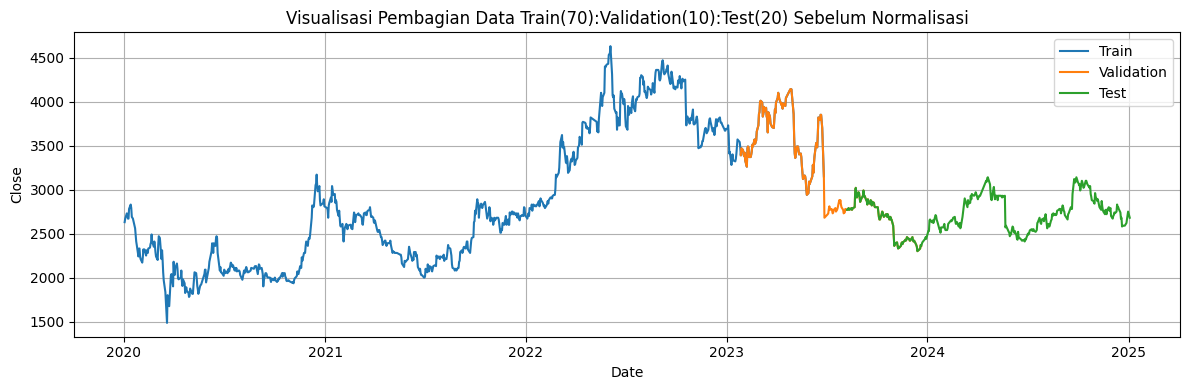

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Inisialisasi Dataset untuk masing-masing subset
root_path = '/content/'  # Ganti jika root_path berbeda
data_path = 'ptba.csv'   # Pastikan file CSV ada di lokasi ini
target_column = 'close' # Changed to lowercase 'close'

# Buat objek dataset untuk train, val, dan test
train_data = PTBADataset(root_path=root_path, flag='train', data_path=data_path, target=target_column)
val_data = PTBADataset(root_path=root_path, flag='val', data_path=data_path, target=target_column)
test_data = PTBADataset(root_path=root_path, flag='test', data_path=data_path, target=target_column)

# Load raw dataframe untuk tanggal
df_raw = pd.read_csv(os.path.join(root_path, data_path))
# Use the correct format for parsing the date column from PTBA2.csv
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y-%m-%d %H:%M:%S')
df_raw = df_raw[['date', target_column]]

# Tentukan pembatas berdasarkan class
num_train = int(len(df_raw) * 0.7)
num_vali  = int(len(df_raw) * 0.1)
num_test  = len(df_raw) - num_train - num_vali

border1s = [0, num_train - train_data.seq_len, len(df_raw) - num_test - train_data.seq_len]
border2s = [num_train, num_train + num_vali, len(df_raw)]

# Ambil data sesuai split
train_plot = df_raw[border1s[0]:border2s[0]]
val_plot = df_raw[border1s[1]:border2s[1]]
test_plot = df_raw[border1s[2]:border2s[2]]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(train_plot['date'], train_plot[target_column], label='Train')
plt.plot(val_plot['date'], val_plot[target_column], label='Validation')
plt.plot(test_plot['date'], test_plot[target_column], label='Test')
plt.xlabel('Date')
plt.ylabel(target_column.capitalize())
plt.title('Visualisasi Pembagian Data Train(70):Validation(10):Test(20) Sebelum Normalisasi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
whos

Variable                           Type                          Data/Info
--------------------------------------------------------------------------
Adam                               type                          <class 'torch.optim.adam.Adam'>
AutoCorrelation                    type                          <class '__main__.AutoCorrelation'>
AutoCorrelationLayer               type                          <class '__main__.AutoCorrelationLayer'>
CORR                               function                      <function CORR at 0x7fe274685300>
DataEmbedding_wo_pos               type                          <class '__main__.DataEmbedding_wo_pos'>
DataLoader                         type                          <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                            type                          <class 'torch.utils.data.dataset.Dataset'>
Dataset_Pred                       type                          <class '__main__.Dataset_Pred'>
DayOfMonth               

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_raw = pd.read_csv('/content/ptba.csv')
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw[['date', 'close']]

scaler = StandardScaler()
num_train = int(len(df_raw) * 0.7)
train_data = df_raw[['close']].iloc[:num_train]

scaler.fit(train_data.values)

joblib.dump(scaler, '/content/scaler.pkl')

df_raw['close_scaled'] = scaler.transform(df_raw[['close']])

df_raw.insert(0, 'No', range(1, 1 + len(df_raw)))

print(df_raw[['No', 'close', 'close_scaled']].head())
print("...")
print(df_raw[['No', 'close', 'close_scaled']].tail())
df_raw.info()

   No  close  close_scaled
0   1   2630     -0.363403
1   2   2670     -0.310933
2   3   2730     -0.232227
3   4   2710     -0.258462
4   5   2670     -0.310933
...
        No  close  close_scaled
1207  1208   2590     -0.415874
1208  1209   2590     -0.415874
1209  1210   2620     -0.376521
1210  1211   2750     -0.205992
1211  1212   2680     -0.297815
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   No            1212 non-null   int64         
 1   date          1212 non-null   datetime64[ns]
 2   close         1212 non-null   int64         
 3   close_scaled  1212 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 38.0 KB


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

df_raw = pd.read_csv('/content/ptba.csv')
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw[['date', 'close']]

df_raw.insert(0, 'No', range(1, 1 + len(df_raw)))

n = len(df_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.1)
n_test = n - n_train - n_val

train_df = df_raw.iloc[:n_train].copy()
val_df   = df_raw.iloc[n_train:n_train + n_val].copy()
test_df  = df_raw.iloc[n_train + n_val:].copy()

scaler = StandardScaler()
scaler.fit(train_df[['close']])

joblib.dump(scaler, '/content/scaler.pkl')

train_df['close_scaled'] = scaler.transform(train_df[['close']])
val_df['close_scaled']   = scaler.transform(val_df[['close']])
test_df['close_scaled']  = scaler.transform(test_df[['close']])

def preview(df, name):
    print(f"\n{name}:")
    display = pd.concat([df.head(), df.tail()])
    print(display[['No', 'date', 'close', 'close_scaled']], "\n")

preview(train_df, "Train")
preview(val_df, "Validation")
preview(test_df, "Test")


Train:
      No                date  close  close_scaled
0      1 2020-01-02 16:00:00   2630     -0.363403
1      2 2020-01-03 16:00:00   2670     -0.310933
2      3 2020-01-06 16:00:00   2730     -0.232227
3      4 2020-01-07 16:00:00   2710     -0.258462
4      5 2020-01-08 16:00:00   2670     -0.310933
843  844 2023-06-20 16:00:00   3850      1.236948
844  845 2023-06-21 16:00:00   3850      1.236948
845  846 2023-06-22 16:00:00   3780      1.145125
846  847 2023-06-23 16:00:00   3700      1.040183
847  848 2023-06-26 16:00:00   3150      0.318714 


Validation:
      No                date  close  close_scaled
848  849 2023-06-27 16:00:00   2680     -0.297815
849  850 2023-07-03 16:00:00   2720     -0.245345
850  851 2023-07-04 16:00:00   2730     -0.232227
851  852 2023-07-05 16:00:00   2780     -0.166639
852  853 2023-07-06 16:00:00   2810     -0.127286
964  965 2023-12-14 16:00:00   2310     -0.783168
965  966 2023-12-15 16:00:00   2310     -0.783168
966  967 2023-12-18 16:00:0

# args

In [ ]:
import argparse
import random
import torch
import numpy as np

def main(arg_list=None):
    fix_seed = 2021
    random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    parser = argparse.ArgumentParser(description='ModelAutoformer for Time Series Forecasting')

    # === Basic Config ===
    parser.add_argument('--is_training', type=int, default=1)
    parser.add_argument('--task_id', type=str, default='ptba_forecast')
    parser.add_argument('--model', type=str, default='ModelAutoformer')

    # === Data Config ===
    parser.add_argument('--data', type=str, default='ptba')
    parser.add_argument('--root_path', type=str, default='/content/')
    parser.add_argument('--data_path', type=str, default='ptba.csv')
    parser.add_argument('--features', type=str, default='S')
    parser.add_argument('--target', type=str, default='close')
    parser.add_argument('--freq', type=str, default='d')
    parser.add_argument('--detail_freq', type=str, default='d')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/')

    # === Forecasting Task ===
    parser.add_argument('--seq_len', type=int, default=96)
    parser.add_argument('--label_len', type=int, default=48)
    parser.add_argument('--pred_len', type=int, default=24)

    # === Model Define ===
    parser.add_argument('--enc_in', type=int, default=1)
    parser.add_argument('--dec_in', type=int, default=1)
    parser.add_argument('--c_out', type=int, default=1)
    parser.add_argument('--d_model', type=int, default=512)
    parser.add_argument('--n_heads', type=int, default=8)
    parser.add_argument('--e_layers', type=int, default=2)
    parser.add_argument('--d_layers', type=int, default=1)
    parser.add_argument('--d_ff', type=int, default=2048)
    parser.add_argument('--moving_avg', type=int, default=25)
    parser.add_argument('--factor', type=int, default=1)
    parser.add_argument('--distil', action='store_false', default=True)
    parser.add_argument('--dropout', type=float, default=0.05)
    parser.add_argument('--embed', type=str, default='timeF')
    parser.add_argument('--activation', type=str, default='gelu')
    parser.add_argument('--output_attention', action='store_true', default=False)

    # === Training Config ===
    parser.add_argument('--num_workers', type=int, default=10)
    parser.add_argument('--do_predict', action='store_true', default=True)

    # === Optimization ===
    parser.add_argument('--itr', type=int, default=1)
    parser.add_argument('--train_epochs', type=int, default=30)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--patience', type=int, default=3)
    parser.add_argument('--learning_rate', type=float, default=0.0001)
    parser.add_argument('--des', type=str, default='run')
    parser.add_argument('--loss', type=str, default='mse')
    parser.add_argument('--lradj', type=str, default='type1')
    parser.add_argument('--use_amp', action='store_true', default=False)

    # === GPU ===
    parser.add_argument('--use_gpu', action='store_true', default=True)
    parser.add_argument('--gpu', type=int, default=0)
    parser.add_argument('--use_multi_gpu', action='store_true', default=False)
    parser.add_argument('--devices', type=str, default='0')

    # === Parse Arguments ===
    if arg_list is not None:
        args = parser.parse_args(arg_list)
    else:
        args = parser.parse_args([])

    # === GPU Config ===
    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]
    else:
        args.device_ids = [args.gpu]

    print('Args in experiment:')
    print(args)

    # === Load Model Class ===
    Exp = Exp_Main

    setting = f'{args.task_id}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_seed{fix_seed}_{args.des}'

    if args.is_training:
        for ii in range(args.itr):
            print(f'>>>>>>>start training : {setting} >>>>>>>>>>>>>>>>>>>>>>>>>>')
            exp = Exp(args)
            exp.train(setting)

            print(f'>>>>>>>testing : {setting} <<<<<<<<<<<<<<<<<<<<<<<<<<<')
            exp.test(setting)

            if args.do_predict:
                print(f'>>>>>>>predicting : {setting} <<<<<<<<<<<<<<<<<<<<<<<<<<<')
                exp.predict(setting)

                result_path = os.path.join("./results", setting, "pred.npy")
                if os.path.exists(result_path):
                    preds = np.load(result_path)

                    plt.figure(figsize=(12,6))
                    plt.plot(preds[0,:,0], label="Prediction")
                    plt.title("Prediction (Batch 0)")
                    plt.legend()
                    plt.show()
                else:
                    print(f"[WARNING] File pred.npy tidak ditemukan di {result_path}")
    else:
        print(f'>>>>>>>testing : {setting} <<<<<<<<<<<<<<<<<<<<<<<<<<<')
        exp = Exp(args)
        exp.test(setting, test=1)
        torch.cuda.empty_cache()

# 512, 0.05, 32, 0.0001, 30, factor (1)

## Train model (120, 60, 30) - (0.8328115)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 699
val set size: 92
Epoch: 1, Steps: 21 | Train Loss: 0.6290684  Vali Loss: 1.0508332 Time: 3.60s
Validation loss decreased (inf --> 1.050833).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 21 | Train Loss: 0.3470739  Vali Loss: 0.8614456 Time: 3.31s
Validation loss decreased (1.050833 --> 0.861446).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 21 | Train Loss: 0.2935636  Vali Loss: 0.8972976 Time: 3.65s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 21 | Train Loss: 0.2752076  Vali Loss: 0.8328116 Time: 3.48s
Validation loss decreased (0.861446 --> 0.832812).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 21 | Train Loss: 0.2582997  Vali Loss: 0.8668746 Time: 3.65s
EarlyStopping counter: 1 out of 3
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 21 | Train Loss: 0.2654712  Vali Loss: 0.8679605 Time: 3.38s
Ea

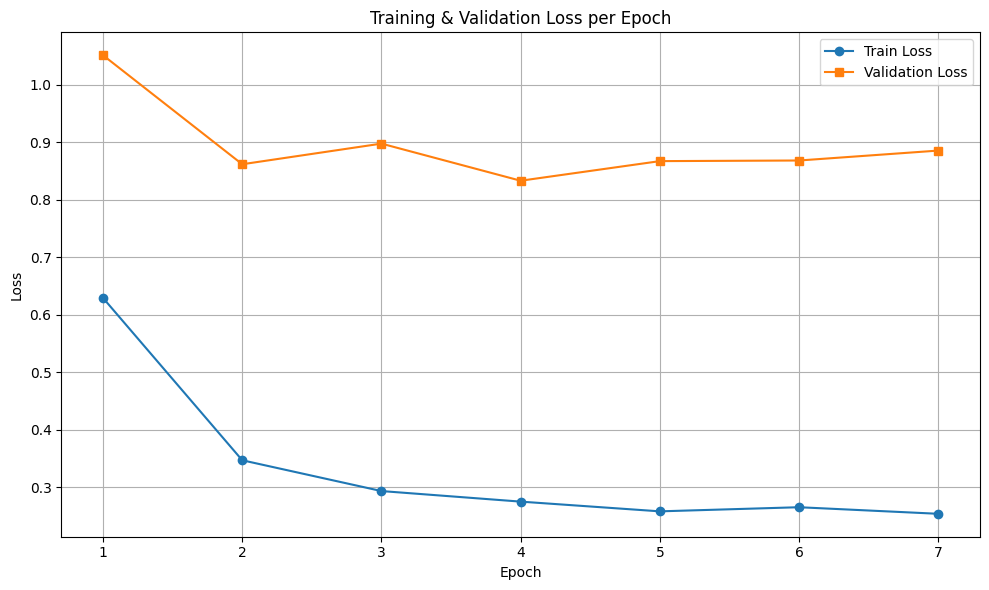

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl120_ll60_pl30_dm512_bs32_f1: 0.8328115940093994


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 120
        self.label_len = 60
        self.pred_len = 30

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

import torch
torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (120, 60, 24) - (0.6302624)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 705
val set size: 98
Epoch: 1, Steps: 22 | Train Loss: 0.4784932  Vali Loss: 0.9819060 Time: 3.43s
Validation loss decreased (inf --> 0.981906).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2796377  Vali Loss: 0.7397149 Time: 3.42s
Validation loss decreased (0.981906 --> 0.739715).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2199670  Vali Loss: 0.6478699 Time: 3.82s
Validation loss decreased (0.739715 --> 0.647870).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.1871049  Vali Loss: 0.6525916 Time: 3.55s
EarlyStopping counter: 1 out of 3
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.1761691  Vali Loss: 0.6302626 Time: 3.41s
Validation loss decreased (0.647870 --> 0.630263).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 22 | Train Loss: 0.1690894  

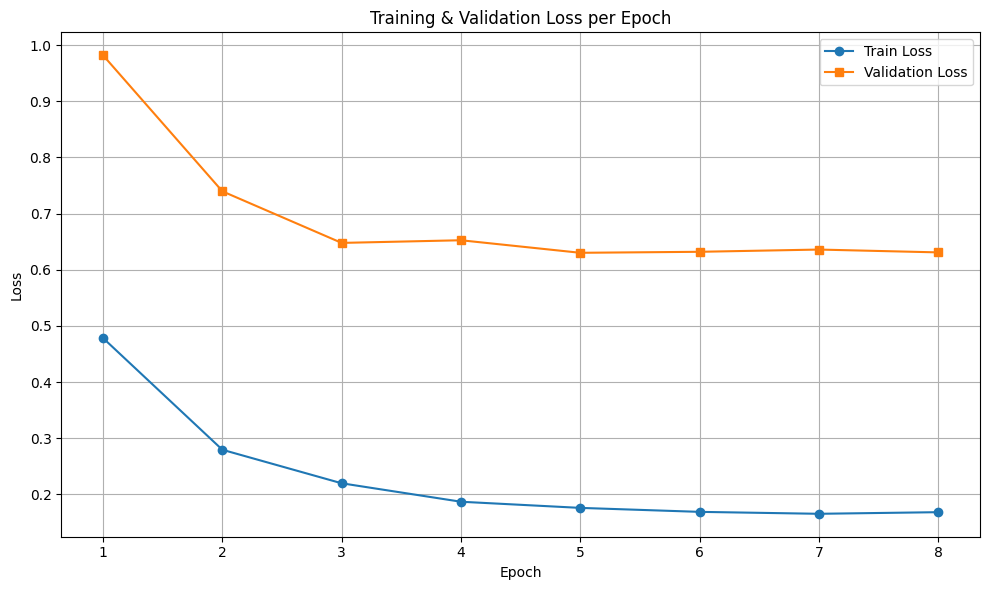

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl120_ll60_pl24_dm512_bs32_f1: 0.630262553691864


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 120
        self.label_len = 60
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (120, 48, 30) - (0.6142315)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 699
val set size: 92
Epoch: 1, Steps: 21 | Train Loss: 0.5849127  Vali Loss: 1.0288737 Time: 3.52s
Validation loss decreased (inf --> 1.028874).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 21 | Train Loss: 0.3420855  Vali Loss: 0.8214863 Time: 3.47s
Validation loss decreased (1.028874 --> 0.821486).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 21 | Train Loss: 0.2882340  Vali Loss: 0.9294206 Time: 3.19s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 21 | Train Loss: 0.2686783  Vali Loss: 0.7617176 Time: 3.17s
Validation loss decreased (0.821486 --> 0.761718).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 21 | Train Loss: 0.2429815  Vali Loss: 0.7646904 Time: 3.19s
EarlyStopping counter: 1 out of 3
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 21 | Train Loss: 0.2326110  Vali Loss: 0.6764784 Time: 3.31s
Va

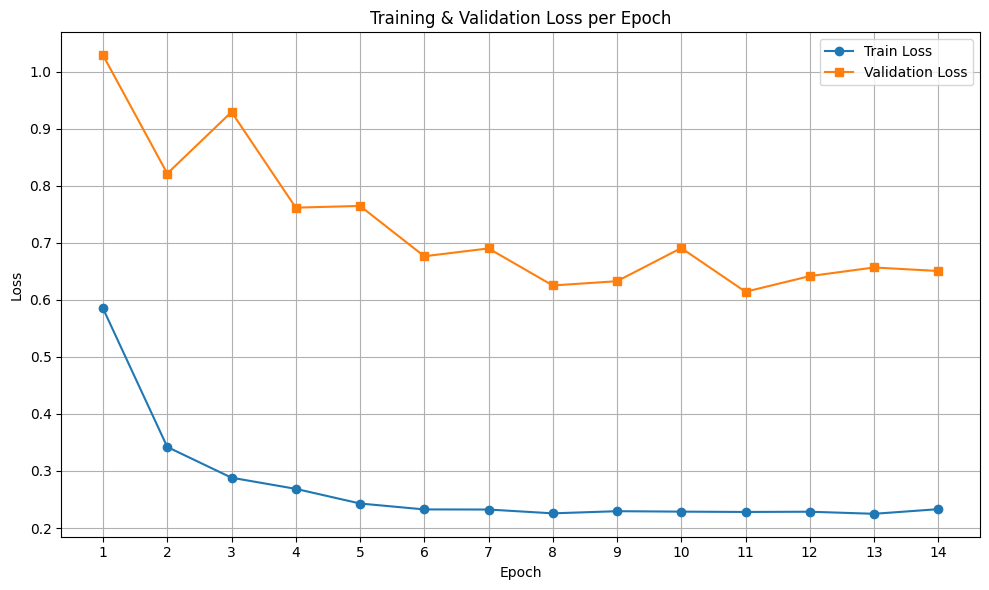

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl120_ll48_pl30_dm512_bs32_f1: 0.6142315566539764


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 120
        self.label_len = 48
        self.pred_len = 30

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training  ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (120, 48, 24) - (0.6716977)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 705
val set size: 98
Epoch: 1, Steps: 22 | Train Loss: 0.6103760  Vali Loss: 0.9674528 Time: 3.42s
Validation loss decreased (inf --> 0.967453).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.3476389  Vali Loss: 0.8005778 Time: 3.32s
Validation loss decreased (0.967453 --> 0.800578).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2978673  Vali Loss: 0.8409936 Time: 3.49s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2747655  Vali Loss: 0.7599358 Time: 3.32s
Validation loss decreased (0.800578 --> 0.759936).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.2569430  Vali Loss: 0.7370738 Time: 3.32s
Validation loss decreased (0.759936 --> 0.737074).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 22 | Train Loss: 0.2562636  

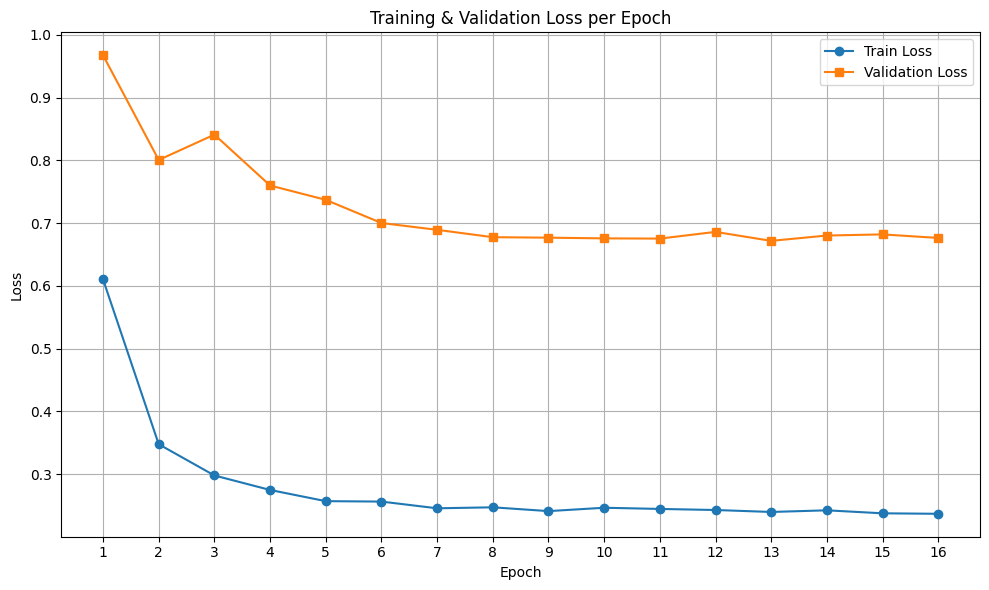

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl120_ll48_pl24_dm512_bs32_f1: 0.671697715918223


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 120
        self.label_len = 48
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (96, 60, 30) - (0.6131397)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 723
val set size: 92
Epoch: 1, Steps: 22 | Train Loss: 0.5953043  Vali Loss: 0.7619604 Time: 3.55s
Validation loss decreased (inf --> 0.761960).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2908724  Vali Loss: 0.6151988 Time: 3.19s
Validation loss decreased (0.761960 --> 0.615199).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2685960  Vali Loss: 0.6310019 Time: 3.15s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2523243  Vali Loss: 0.6131398 Time: 3.17s
Validation loss decreased (0.615199 --> 0.613140).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.2416519  Vali Loss: 0.7147906 Time: 3.33s
EarlyStopping counter: 1 out of 3
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 22 | Train Loss: 0.2358250  Vali Loss: 0.6859966 Time: 3.24s
Ea

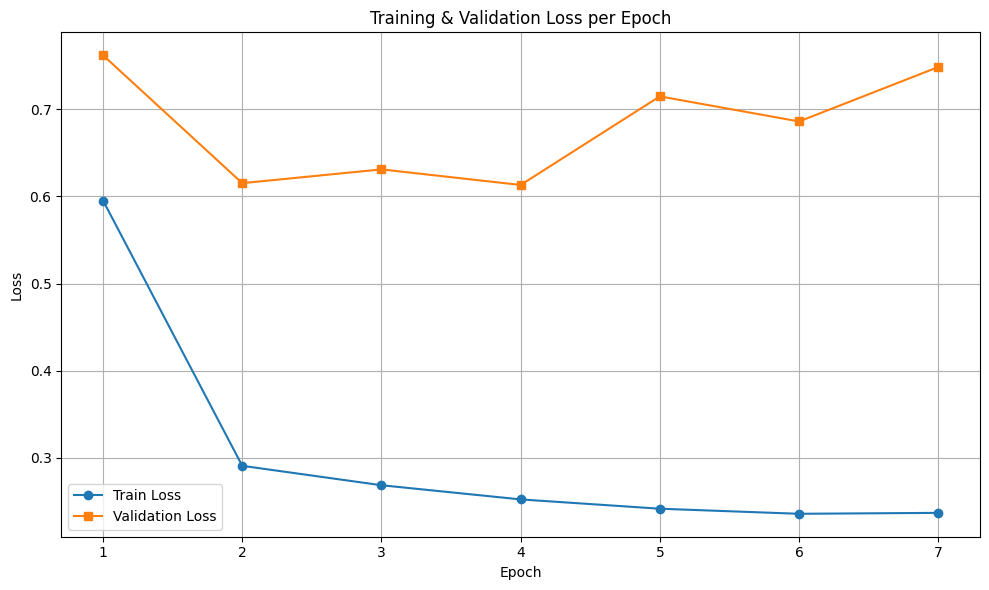

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl96_ll60_pl30_dm512_bs32_f1: 0.6131397783756256


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 60
        self.pred_len = 30

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training  ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (96, 60, 24) - (0.5737872)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 729
val set size: 98
Epoch: 1, Steps: 22 | Train Loss: 0.5436292  Vali Loss: 0.7206075 Time: 4.87s
Validation loss decreased (inf --> 0.720607).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2589293  Vali Loss: 0.5737872 Time: 2.88s
Validation loss decreased (0.720607 --> 0.573787).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2205984  Vali Loss: 0.7499286 Time: 2.85s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2064479  Vali Loss: 0.6532221 Time: 2.89s
EarlyStopping counter: 2 out of 3
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.1995799  Vali Loss: 0.7028876 Time: 3.05s
EarlyStopping counter: 3 out of 3
Early stopping


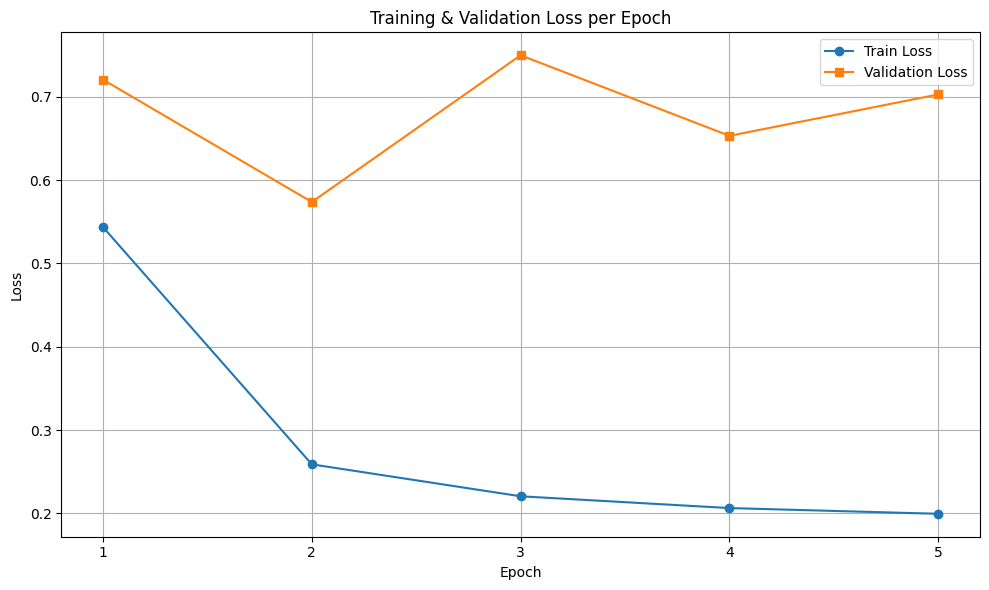

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl96_ll60_pl24_dm512_bs32_f1: 0.5737871527671814


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 60
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False


args = Config()

# --- Training ---
exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

Use GPU: cuda:0
>>> Mulai training ulang model terbaik...
train set size: 729
val set size: 98
Epoch: 1, Steps: 22 | Train Loss: 0.5436292  Vali Loss: 0.7206075 Time: 2.93s
Validation loss decreased (inf --> 0.720607).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2589293  Vali Loss: 0.5737872 Time: 3.01s
Validation loss decreased (0.720607 --> 0.573787).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2205984  Vali Loss: 0.7499286 Time: 2.89s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2064479  Vali Loss: 0.6532221 Time: 2.90s
EarlyStopping counter: 2 out of 3
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.1995799  Vali Loss: 0.7028876 Time: 2.88s
EarlyStopping counter: 3 out of 3
Early stopping


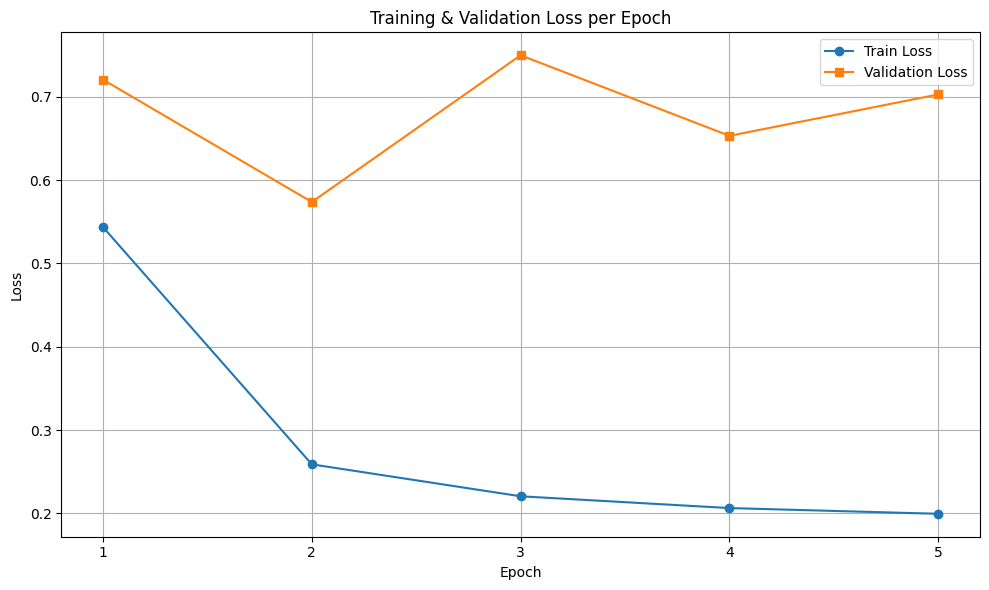

>>> Model disimpan ke best_model.pth
>>> Evaluasi model di test set...
test set size: 220
MAE: 0.2821, MSE: 0.1328, RMSE: 0.3644, MAPE: 3.0165
>>> Lanjut prediksi di test set...
Prediction set size: 1


In [ ]:
import torch
import numpy as np
import random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 60
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = True

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'retrain'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False

args = Config()

exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training ulang model terbaik...")
exp.train(setting)

torch.save(exp.model.state_dict(), "96-60-24.pth")
print(">>> Model disimpan ke best_model.pth")

print(">>> Evaluasi model di test set...")
exp.test(setting)

if args.do_predict:
    print(">>> Lanjut prediksi di test set...")
    exp.predict(setting)

In [ ]:
import torch
import torchinfo
from torchinfo import summary

class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 60
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False

args = Config()

exp = Exp_Main(args)
exp.model.load_state_dict(torch.load("96-60-24.pth", map_location=exp.device))
exp.model.to(exp.device)
exp.model.eval()

batch_size = 32
batch_x = torch.randn(batch_size, args.seq_len, args.enc_in).to(exp.device)
batch_x_mark = torch.randn(batch_size, args.seq_len, 3).to(exp.device)
batch_y = torch.randn(batch_size, args.label_len + args.pred_len, args.dec_in).to(exp.device)
batch_y_mark = torch.randn(batch_size, args.label_len + args.pred_len, 3).to(exp.device)      # (32, 84, 3)

summary(exp.model, input_data=[batch_x, batch_x_mark, batch_y, batch_y_mark],
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        depth=4)

Use GPU: cuda:0


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ModelAutoformer                                    [32, 96, 1]               [32, 24, 1]               --                        --
├─series_decomp: 1-1                               [32, 96, 1]               [32, 96, 1]               --                        --
│    └─moving_avg: 2-1                             [32, 96, 1]               [32, 96, 1]               --                        25
│    │    └─AvgPool1d: 3-1                         [32, 1, 120]              [32, 1, 96]               --                        [25]
├─DataEmbedding_wo_pos: 1-2                        [32, 96, 1]               [32, 96, 512]             --                        --
│    └─TokenEmbedding: 2-2                         [32, 96, 1]               [32, 96, 512]             --                        --
│    │    └─Conv1d: 3-2                            [32, 1, 96]  

In [ ]:
import torch
import pandas as pd

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp = Exp_Main(args)
exp.model.load_state_dict(torch.load("96-60-24.pth", map_location=args.device))
exp.model.to(args.device)
exp.model.eval()

rows = []
for idx, (name, param) in enumerate(exp.model.named_parameters(), start=1):
    if param.requires_grad:
        shape = list(param.shape)
        num_params = param.numel()
        sample_values = param.view(-1)[:5].detach().cpu().numpy()

        if "weight" in name:
            layer_name = f"{idx}. {name} - Bobot"
        elif "bias" in name:
            layer_name = f"{idx}. {name} - Bias"
        else:
            layer_name = f"{idx}. {name}"

        rows.append([layer_name, shape, num_params, sample_values])

df_params = pd.DataFrame(rows, columns=["Layer", "Shape", "Jumlah Parameter", "Cuplikan Nilai"])

df_params

Use GPU: cuda:0


,Layer,Shape,Jumlah Parameter,Cuplikan Nilai
0,1. enc_embedding.value_embedding.tokenConv.wei...,"[512, 1, 3]",1536,"[-0.5878119, -0.46111658, 0.08549864, -0.64731..."
1,2. enc_embedding.temporal_embedding.embed.weig...,"[512, 3]",1536,"[0.2568476, -0.12803265, -0.28813234, 0.020096..."
2,3. dec_embedding.value_embedding.tokenConv.wei...,"[512, 1, 3]",1536,"[0.13914879, 0.28151456, 1.50241, -1.1489725, ..."
3,4. dec_embedding.temporal_embedding.embed.weig...,"[512, 3]",1536,"[0.12767814, -0.23737256, 0.45046616, 0.345185..."
4,5. encoder.attn_layers.0.attention.query_proje...,"[512, 512]",262144,"[0.027058335, -0.011585236, -0.0069121867, 0.0..."
5,6. encoder.attn_layers.0.attention.query_proje...,[512],512,"[-0.0003484161, -0.037042163, 0.002671666, -0...."
6,7. encoder.attn_layers.0.attention.key_project...,"[512, 512]",262144,"[0.0051481193, -0.015689548, -0.0051855072, -0..."
7,8. encoder.attn_layers.0.attention.key_project...,[512],512,"[-0.033145566, -0.0021929492, -0.03435456, -0...."
8,9. encoder.attn_layers.0.attention.value_proje...,"[512, 512]",262144,"[-0.024857275, 0.022713505, 0.030621001, 0.042..."
9,10. encoder.attn_layers.0.attention.value_proj...,[512],512,"[0.02059193, 0.023138858, 0.00297635, 0.027308..."


In [ ]:
df_params.to_csv("bobot_bias_autoformer.csv", index=False)

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import joblib
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

exp = Exp_Main(args)

exp.model.load_state_dict(torch.load("96-60-24.pth", map_location=exp.device))
exp.model.eval()

print("\n--- Prediksi pada Test Set ---")

_, test_loader = exp._get_data(flag='test')

preds_list = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        outputs = exp.model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]

        preds_list.append(outputs.detach().cpu().numpy())

preds = np.concatenate(preds_list, axis=0)
print("Shape preds:", preds.shape)

scaler = joblib.load("scaler.pkl")
preds_denorm = scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)

data_all = pd.read_csv("ptba.csv")
data_all['date'] = pd.to_datetime(data_all['date'])
n_total = len(data_all)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)
test_data = data_all.iloc[n_train+n_val:].reset_index(drop=True)

dates_batch0 = test_data['date'].iloc[:args.pred_len].reset_index(drop=True)

batch0_pred_norm = preds[0, :, 0]
batch0_true_norm = scaler.transform(
    test_data['close'].iloc[:args.pred_len].values.reshape(-1, 1)
).reshape(-1)

batch0_true_denorm = test_data['close'].iloc[:args.pred_len].values
batch0_pred_denorm = preds_denorm[0, :, 0]

df_batch0 = pd.DataFrame({
    "Date": dates_batch0,
    "Pred_norm": batch0_pred_norm,
    "True_norm": batch0_true_norm,
    "Pred_denorm": batch0_pred_denorm,
    "True_denorm": batch0_true_denorm
})

print("\nBatch 0 test set (prediksi norm & denorm):")
print(df_batch0)

Use GPU: cuda:0

--- Prediksi pada Test Set ---
test set size: 220
Shape preds: (192, 24, 1)

Batch 0 test set (prediksi norm & denorm):
                  Date  Pred_norm  True_norm  Pred_denorm  True_denorm
0  2023-12-21 16:00:00  -0.117598  -0.691344  2817.385254         2380
1  2023-12-22 16:00:00  -0.162968  -0.665109  2782.798096         2400
2  2023-12-27 16:00:00  -0.258414  -0.612638  2710.036865         2440
3  2023-12-28 16:00:00  -0.313625  -0.586403  2667.947510         2460
4  2023-12-29 16:00:00  -0.296234  -0.612638  2681.205322         2440
5  2024-01-02 16:00:00  -0.511708  -0.494580  2516.942383         2530
6  2024-01-03 16:00:00  -0.569915  -0.494580  2472.569092         2530
7  2024-01-04 16:00:00  -0.587106  -0.337168  2459.463867         2650
8  2024-01-05 16:00:00  -0.570239  -0.324050  2472.322510         2660
9  2024-01-08 16:00:00  -0.511541  -0.363403  2517.070068         2630
10 2024-01-09 16:00:00  -0.420932  -0.363403  2586.143799         2630
11 2024-01-

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import joblib
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

exp = Exp_Main(args)

exp.model.load_state_dict(torch.load("96-60-24.pth", map_location=exp.device))
exp.model.eval()

print("\n--- Prediksi pada Test Set ---")

_, test_loader = exp._get_data(flag='test')

preds_list = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        outputs = exp.model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]

        preds_list.append(outputs.detach().cpu().numpy())

preds = np.concatenate(preds_list, axis=0)
print("Shape preds:", preds.shape)

scaler = joblib.load("scaler.pkl")
preds_denorm = scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)

data_all = pd.read_csv("ptba.csv")
data_all['date'] = pd.to_datetime(data_all['date'])
n_total = len(data_all)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)
test_data = data_all.iloc[n_train+n_val:].reset_index(drop=True)

dates_batch0 = test_data['date'].iloc[:args.pred_len].reset_index(drop=True)
batch0_true_denorm = test_data['close'].iloc[:args.pred_len].values
batch0_pred_denorm = preds_denorm[0, :, 0]

df_batch0 = pd.DataFrame({
    "Date": dates_batch0,
    "Pred_denorm": batch0_pred_denorm,
    "True_denorm": batch0_true_denorm
})

print("\nBatch 0 test set (prediksi vs harga asli CSV):")
print(df_batch0)

print("\n--- Forecast Data Baru ---")

pred_dataset = Dataset_Pred(
    root_path=args.root_path,
    flag='pred',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    data_path=args.data_path,
    target=args.target,
    scale=True,
    inverse=False,
    timeenc=0 if args.embed != 'timeF' else 1,
    freq=args.freq
)
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for batch_x, batch_y, batch_x_mark, batch_y_mark in pred_loader:
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        forecast = exp.model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        forecast = forecast[:, -args.pred_len:, :].cpu().numpy()

forecast_original = pred_dataset.inverse_transform(forecast.reshape(-1, 1))

print("\nForecast shape:", forecast_original.shape)
print("Forecast values:", forecast_original.ravel())

Use GPU: cuda:0

--- Prediksi pada Test Set ---
test set size: 220
Shape preds: (192, 24, 1)

Batch 0 test set (prediksi vs harga asli CSV):
                  Date  Pred_denorm  True_denorm
0  2023-12-21 16:00:00  2817.385254         2380
1  2023-12-22 16:00:00  2782.798096         2400
2  2023-12-27 16:00:00  2710.036865         2440
3  2023-12-28 16:00:00  2667.947510         2460
4  2023-12-29 16:00:00  2681.205322         2440
5  2024-01-02 16:00:00  2516.942383         2530
6  2024-01-03 16:00:00  2472.569092         2530
7  2024-01-04 16:00:00  2459.463867         2650
8  2024-01-05 16:00:00  2472.322510         2660
9  2024-01-08 16:00:00  2517.070068         2630
10 2024-01-09 16:00:00  2586.143799         2630
11 2024-01-10 16:00:00  2638.811768         2650
12 2024-01-11 16:00:00  2647.938965         2620
13 2024-01-12 16:00:00  2578.040527         2640
14 2024-01-15 16:00:00  2511.201660         2710
15 2024-01-16 16:00:00  2482.485596         2700
16 2024-01-17 16:00:00  24

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch0_pred = preds[0, :, 0]
batch0_pred_denorm = scaler.inverse_transform(batch0_pred.reshape(-1,1)).ravel()

batch0_true_denorm = test_data['close'].iloc[:args.pred_len].values

mae = mean_absolute_error(batch0_true_denorm, batch0_pred_denorm)
mse = mean_squared_error(batch0_true_denorm, batch0_pred_denorm)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((batch0_true_denorm - batch0_pred_denorm) / batch0_true_denorm)) * 100

print("\n=== Evaluasi Test Set (Batch 0) ===")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}%")

df_eval = pd.DataFrame({
    "Date": dates_batch0,
    "True": batch0_true_denorm,
    "Pred": batch0_pred_denorm
})

df_eval.to_csv("eval_96-60-24.csv", index=False)
print("\nHasil prediksi vs true sudah disimpan ke eval_prediksi.csv")

with open("eval_metrics.txt", "w") as f:
    f.write(f"MAE : {mae:.4f}\n")
    f.write(f"MSE : {mse:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"MAPE: {mape:.4f}%\n")

print("Metrik evaluasi sudah disimpan ke eval_metrics.txt")


=== Evaluasi Test Set (Batch 0) ===
MAE  : 172.5230
MSE  : 41135.0117
RMSE : 202.8177
MAPE : 6.8032%

Hasil prediksi vs true sudah disimpan ke eval_prediksi.csv
Metrik evaluasi sudah disimpan ke eval_metrics.txt


In [ ]:
import pandas as pd
import numpy as np

last_date = data_all['date'].iloc[-1]

forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=args.pred_len,
    freq='B'
)

forecast_values = forecast_original.ravel()

df_forecast = pd.DataFrame({
    "Date": forecast_dates,
    "Forecast": forecast_values
})

print("Forecast untuk data yang tidak dimiliki:")
print(df_forecast)

Forecast untuk data yang tidak dimiliki:
                  Date     Forecast
0  2025-01-03 16:00:00  2666.173340
1  2025-01-06 16:00:00  2678.673340
2  2025-01-07 16:00:00  2682.205566
3  2025-01-08 16:00:00  2676.317627
4  2025-01-09 16:00:00  2706.981201
5  2025-01-10 16:00:00  2750.930664
6  2025-01-13 16:00:00  2835.289307
7  2025-01-14 16:00:00  2889.800293
8  2025-01-15 16:00:00  2880.002930
9  2025-01-16 16:00:00  2866.118408
10 2025-01-17 16:00:00  2901.561768
11 2025-01-20 16:00:00  2920.824707
12 2025-01-21 16:00:00  2935.806152
13 2025-01-22 16:00:00  2910.355713
14 2025-01-23 16:00:00  2873.623047
15 2025-01-24 16:00:00  2845.011475
16 2025-01-27 16:00:00  2795.916504
17 2025-01-28 16:00:00  2716.372803
18 2025-01-29 16:00:00  2658.394043
19 2025-01-30 16:00:00  2586.365723
20 2025-01-31 16:00:00  2540.819824
21 2025-02-03 16:00:00  2482.251465
22 2025-02-04 16:00:00  2449.843506
23 2025-02-05 16:00:00  2437.658447


test set size: 220
Evaluasi Prediksi Test (FULL rolling, warm-start train+val tail):
MAE  : 157.4801
MSE  : 42000.1321
MAPE : 5.68%


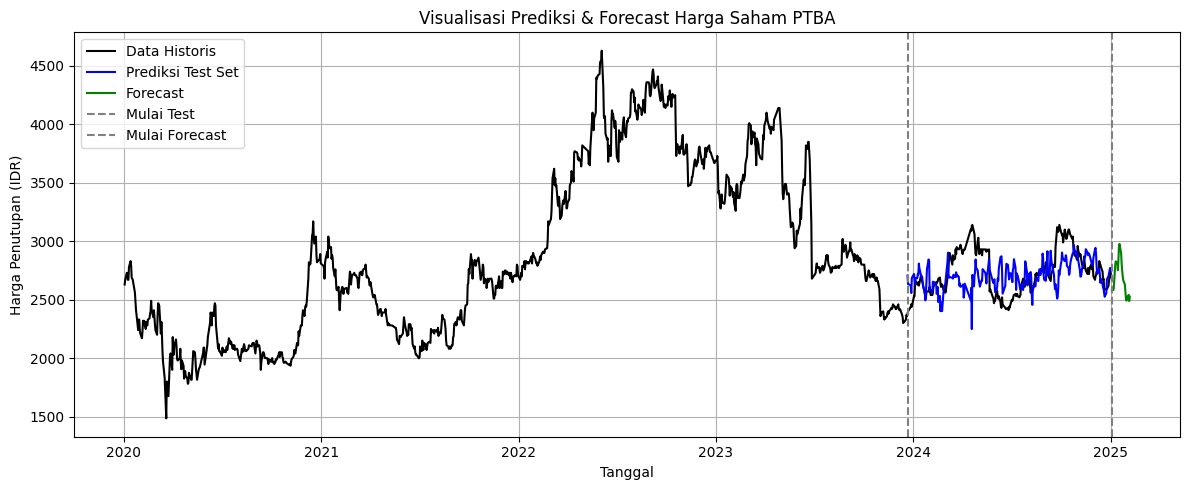

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error

df_all = pd.read_csv("ptba.csv")
df_all["date"] = pd.to_datetime(df_all["date"])
df_all = df_all.sort_values("date").reset_index(drop=True)

n_total = len(df_all)
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.1)
n_test  = n_total - (n_train + n_val)

test_data = df_all.iloc[n_train + n_val :].reset_index(drop=True)

seq_len = args.seq_len
pred_len = args.pred_len
label_len = args.label_len

scaler = joblib.load("scaler.pkl")

_, test_loader = data_provider(args, "test")
_, _, batch_x_mark, _ = next(iter(test_loader))
time_feat_dim = batch_x_mark.shape[-1]

start_test_idx = n_train + n_val
seed_vals = df_all["close"].values[start_test_idx - seq_len : start_test_idx]
seed_scaled = scaler.transform(seed_vals.reshape(-1, 1)).reshape(1, seq_len, 1)

seq = seed_scaled.copy()
rolling_preds = []

for t in range(len(test_data)):
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(exp.device)
    x_mark  = torch.zeros((1, seq_len, time_feat_dim)).to(exp.device)
    dec_inp = torch.zeros((1, label_len + pred_len, 1)).to(exp.device)
    dec_mark= torch.zeros((1, label_len + pred_len, time_feat_dim)).to(exp.device)

    with torch.no_grad():
        out = exp.model(seq_tensor, x_mark, dec_inp, dec_mark)
        step_pred = out[:, -pred_len:, :].detach().cpu().numpy()[:, 0, :]

    rolling_preds.append(step_pred.item())
    seq = np.append(seq[:, 1:, :], step_pred.reshape(1, 1, 1), axis=1)

rolling_preds = np.array(rolling_preds).reshape(-1, 1)
rolling_preds_denorm = scaler.inverse_transform(rolling_preds).reshape(-1)

true_test_values = test_data["close"].values
test_dates = test_data["date"].values

last_seq_vals = df_all["close"].values[-seq_len:]
last_seq_scaled = scaler.transform(last_seq_vals.reshape(-1, 1)).reshape(1, seq_len, 1)
last_seq_tensor = torch.tensor(last_seq_scaled, dtype=torch.float32).to(exp.device)

last_x_mark  = torch.zeros((1, seq_len, time_feat_dim)).to(exp.device)
dec_inp_f    = torch.zeros((1, label_len + pred_len, 1)).to(exp.device)
dec_mark_f   = torch.zeros((1, label_len + pred_len, time_feat_dim)).to(exp.device)

with torch.no_grad():
    f_out = exp.model(last_seq_tensor, last_x_mark, dec_inp_f, dec_mark_f)
    f_pred = f_out[:, -pred_len:, :].detach().cpu().numpy()

forecast_denorm = scaler.inverse_transform(f_pred.reshape(-1, 1)).reshape(-1)
start_forecast_date = df_all["date"].iloc[-1] + pd.Timedelta(days=1)
forecast_dates = pd.bdate_range(start=start_forecast_date, periods=pred_len)

mae = mean_absolute_error(true_test_values, rolling_preds_denorm)
mse = mean_squared_error(true_test_values, rolling_preds_denorm)
mape = np.mean(np.abs((true_test_values - rolling_preds_denorm) / true_test_values)) * 100

print("Evaluasi Prediksi Test (FULL rolling, warm-start train+val tail):")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"MAPE : {mape:.2f}%")

plt.figure(figsize=(12,5))

plt.plot(df_all["date"], df_all["close"], label="Data Historis", color="black")

plt.plot(test_dates, rolling_preds_denorm, label="Prediksi Test Set", color="blue")

plt.plot(forecast_dates, forecast_denorm, label="Forecast", color="green")

plt.axvline(x=df_all["date"].iloc[start_test_idx], color="gray", linestyle="--", label="Mulai Test")
plt.axvline(x=df_all["date"].iloc[-1], color="gray", linestyle="--", label="Mulai Forecast")

plt.title("Visualisasi Prediksi & Forecast Harga Saham PTBA")
plt.xlabel("Tanggal"); plt.ylabel("Harga Penutupan (IDR)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

Use GPU: cuda:0
test set size: 220


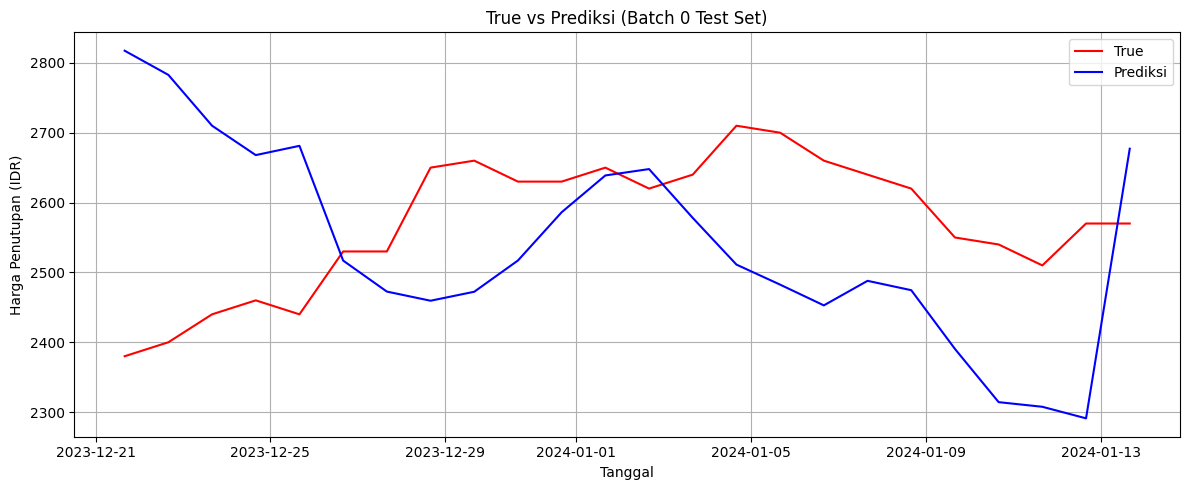

In [ ]:
import matplotlib.pyplot as plt
import joblib
import torch
import numpy as np
import pandas as pd

exp = Exp_Main(args)
exp.model.load_state_dict(torch.load("96-60-24.pth", map_location=exp.device))
exp.model.eval()

_, test_loader = data_provider(args, 'test')

batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(test_loader))

with torch.no_grad():
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float().to(exp.device)
    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)

    outputs = exp.model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()
    trues = batch_y[:, -args.pred_len:, :].detach().cpu().numpy()

scaler = joblib.load("scaler.pkl")
preds_denorm = scaler.inverse_transform(
    preds.reshape(-1, preds.shape[-1])
).reshape(preds.shape)[0, :, 0]

trues_denorm = scaler.inverse_transform(
    trues.reshape(-1, trues.shape[-1])
).reshape(trues.shape)[0, :, 0]

df_all = pd.read_csv("ptba.csv")
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values('date').reset_index(drop=True)

n_total = len(df_all)
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.1)
test_df = df_all.iloc[n_train+n_val:].reset_index(drop=True)

start_date = test_df['date'].iloc[0]

start_date = test_df['date'].iloc[0]
dates_pred = pd.date_range(start=start_date, periods=args.pred_len, freq='D')

plt.figure(figsize=(12,5))
plt.plot(dates_pred, trues_denorm, label='True', color='red')
plt.plot(dates_pred, preds_denorm, label='Prediksi', color='blue')

plt.title("True vs Prediksi (Batch 0 Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Penutupan (IDR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model (96, 48, 30) - (0.6956527)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 723
val set size: 92
Epoch: 1, Steps: 22 | Train Loss: 0.4893391  Vali Loss: 0.8344690 Time: 3.19s
Validation loss decreased (inf --> 0.834469).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2890460  Vali Loss: 0.7108697 Time: 3.27s
Validation loss decreased (0.834469 --> 0.710870).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2268220  Vali Loss: 0.7261169 Time: 3.07s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2042849  Vali Loss: 0.6956528 Time: 3.05s
Validation loss decreased (0.710870 --> 0.695653).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.1872870  Vali Loss: 0.7837069 Time: 3.37s
EarlyStopping counter: 1 out of 3
Updating learning rate to 6.25e-06
Epoch: 6, Steps: 22 | Train Loss: 0.1846504  Vali Loss: 0.7132637 Time: 3.23s
Ea

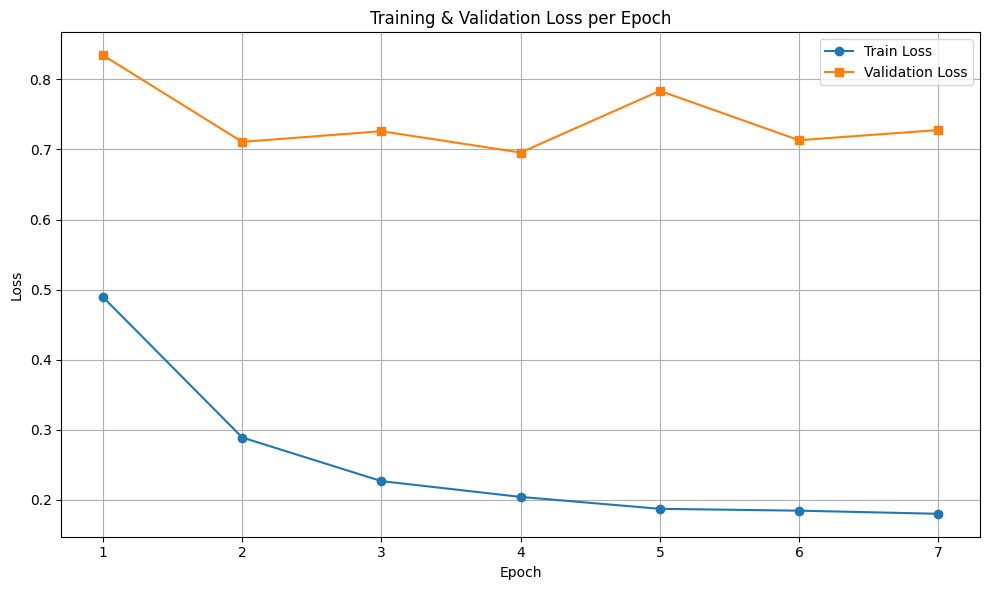

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl96_ll48_pl30_dm512_bs32_f1: 0.6956527829170227


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 48
        self.pred_len = 30

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False

args = Config()

exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")

## Train model (96, 48, 24) - (0.6022988)

In [ ]:
import torch, numpy as np, random

seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Use GPU: cuda:0
>>> Mulai training (tuning manual)...
train set size: 729
val set size: 98
Epoch: 1, Steps: 22 | Train Loss: 0.4482892  Vali Loss: 0.7523360 Time: 3.09s
Validation loss decreased (inf --> 0.752336).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2, Steps: 22 | Train Loss: 0.2581885  Vali Loss: 0.6022988 Time: 3.48s
Validation loss decreased (0.752336 --> 0.602299).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3, Steps: 22 | Train Loss: 0.2303176  Vali Loss: 0.8172371 Time: 3.17s
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 22 | Train Loss: 0.2186919  Vali Loss: 0.6924131 Time: 3.02s
EarlyStopping counter: 2 out of 3
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 22 | Train Loss: 0.2150611  Vali Loss: 0.7540993 Time: 3.05s
EarlyStopping counter: 3 out of 3
Early stopping


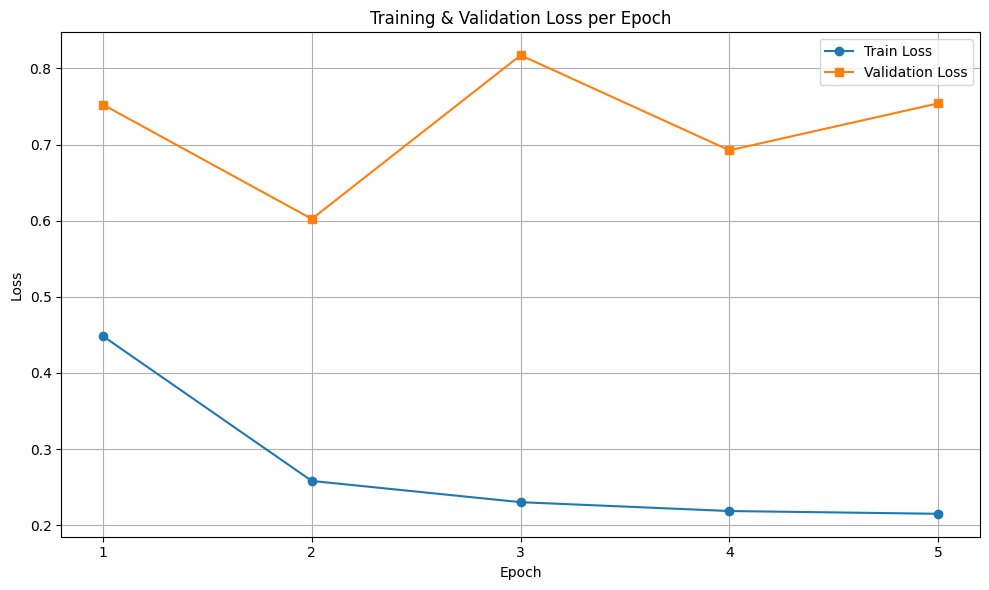

>>> Hasil validasi konfigurasi ptba_ModelAutoformer_sl96_ll48_pl24_dm512_bs32_f1: 0.6022988160451254


In [ ]:
class Config:
    def __init__(self):
        self.model = 'ModelAutoformer'
        self.data = 'ptba'
        self.root_path = './'
        self.data_path = 'ptba.csv'
        self.features = 'S'
        self.target = 'close'
        self.freq = 'd'
        self.detail_freq = 'd'
        self.checkpoint = './chechpoints/'

        self.seq_len = 96
        self.label_len = 48
        self.pred_len = 24

        self.e_layers = 2
        self.d_layers = 1
        self.moving_avg = 25
        self.factor = 1
        self.d_model = 512
        self.n_heads = 8
        self.d_ff = 2048
        self.dropout = 0.05
        self.activation = 'gelu'
        self.num_workers = 10
        self.do_predict = False

        self.batch_size = 32
        self.learning_rate = 0.0001
        self.loss = 'MSE'
        self.optimizer = 'Adam'
        self.train_epochs = 30
        self.patience = 3
        self.itr = 1
        self.des = 'run'
        self.lradj = 'type1'
        self.use_amp = False

        self.enc_in = 1
        self.dec_in = 1
        self.c_out = 1
        self.distil = True
        self.embed = 'timeF'

        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'
        self.output_attention = False

args = Config()

exp = Exp_Main(args)
setting = f'{args.data}_{args.model}_sl{args.seq_len}_ll{args.label_len}_pl{args.pred_len}_dm{args.d_model}_bs{args.batch_size}_f{args.factor}'

print(">>> Mulai training (tuning manual)...")
vali_loss = exp.train(setting)

torch.save(exp.model.state_dict(), f"{setting}.pth")

print(f">>> Hasil validasi konfigurasi {setting}: {vali_loss}")